<a href="https://www.kaggle.com/code/ayakouks/fake-news-detection?scriptVersionId=176876870" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 style="font-size: 70px;text-align: center; font-family:Copperplate; color: darkblue">Fake News Detection</h1>


***
<h3 style="font-size: 45px; text-align: center; font-family: Copperplate; color: darkblue; background-color: white;">EDA</h3>


In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
import regex as re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/fake-news-detection-datasets/News _dataset/True.csv
/kaggle/input/fake-news-detection-datasets/News _dataset/Fake.csv


In [2]:
real = pd.read_csv("/kaggle/input/fake-news-detection-datasets/News _dataset/True.csv")
fake = pd.read_csv("/kaggle/input/fake-news-detection-datasets/News _dataset/Fake.csv")

**Let's start by first adding the target value to our real and fake news as 1 , 0 then concatenating both datasets** + **let's shuffle our data and set the seed to ensure reproducibility**

In [3]:
real['target']=1
fake['target']=0

data = pd.concat([real , fake] , ignore_index=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)


display(data.head())
print('-'*40)

print('shape' , data.shape)
print('-'*40)

display(data.dtypes )
print('-'*40)

display(data.isna().sum())


,title,text,subject,date,target
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0


----------------------------------------
shape (44898, 5)
----------------------------------------


title      object
text       object
subject    object
date       object
target      int64
dtype: object

----------------------------------------


title      0
text       0
subject    0
date       0
target     0
dtype: int64

In [4]:
data.target.value_counts(normalize=True)


target
0    0.522985
1    0.477015
Name: proportion, dtype: float64

<Axes: xlabel='target', ylabel='count'>

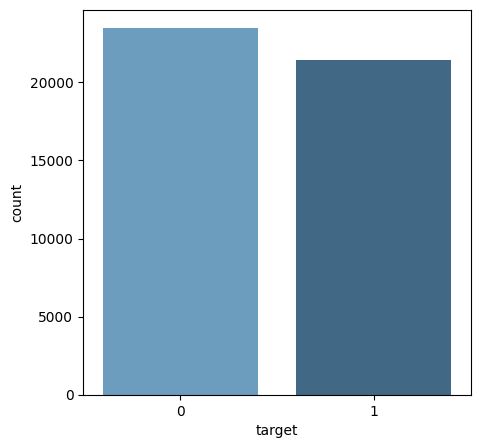

In [5]:
import seaborn as sns  # Import de la bibliothèque Seaborn pour la visualisation de données

def create_distribution(dataFile):
    plt.figure(figsize=(5, 5)) 

    return sns.countplot(x='target', data=dataFile,palette='Blues_d')
create_distribution(data)



 <div style = "height: 210px;
  width: 800px;
  border:5px inset blue;
  background-color: #e2e1e9;">
    <h3 style="
              color:black;
               ">
        <b>Observations:</b> 
        
 <p>
     <ol>
         <li>There are a total of 5 columns and 44898 rows in the data</li>
         <li>target is our target/label variable</li>
         <li>Percentage of Real and fake News articles:<ul><li>real : 47.7%</li><li>fake :52.2%</li></ul></li>
         <li>There are no missing values</li>
    </ol>
 </p>
    </h3>

</div>

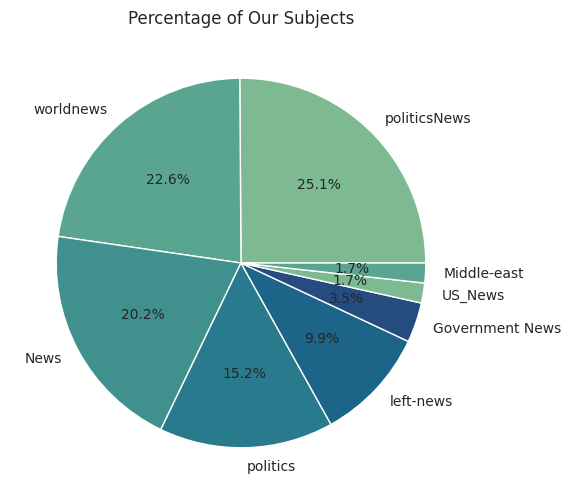

In [6]:

sns.set_palette("crest")  
sns.set_style("whitegrid")  

plt.figure(figsize=(6, 6)) 
data['subject'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Percentage of Our Subjects')
plt.ylabel(None) 
plt.show()


In [7]:
# def encode_subject(label):
#     if label  in ["politicsNews",'politics' ,'Government News','left-news']:
#         return "politics"
#     elif label  in ['worldnews' ,'News']:
#         return "world news"
#     else:
#         return "US_News"

# data["subject"]=data["subject"].apply(encode_subject) 
data.subject=data.subject.replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})


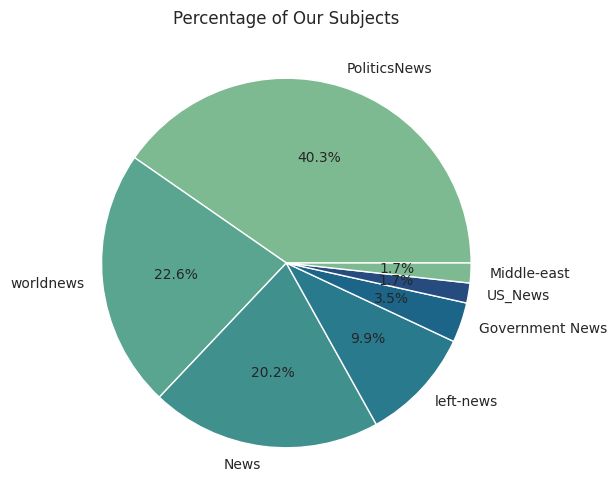

In [8]:
sns.set_palette("crest")  
sns.set_style("whitegrid")  

plt.figure(figsize=(6, 6)) 
data['subject'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Percentage of Our Subjects')
plt.ylabel(None) 
plt.show()


***

#### As an estimate what subjects have more fake news **rs1** , and which of them have real news **rs2** ?


In [9]:
rs1 = data[data['target'] == 0].groupby(['subject'], as_index=False).size()
rs1 = rs1.rename(columns={'size': 'count'}).sort_values(by='count', ascending=False)
print(rs1)

           subject  count
2             News   9050
3     PoliticsNews   6841
5        left-news   4459
0  Government News   1570
4          US_News    783
1      Middle-east    778


In [10]:
rs2 = data[data['target'] == 1].groupby(['subject'], as_index=False).size()
rs2 = rs2.rename(columns={'size': 'count'}).sort_values(by='count', ascending=False)
print(rs2)

        subject  count
0  PoliticsNews  11272
1     worldnews  10145


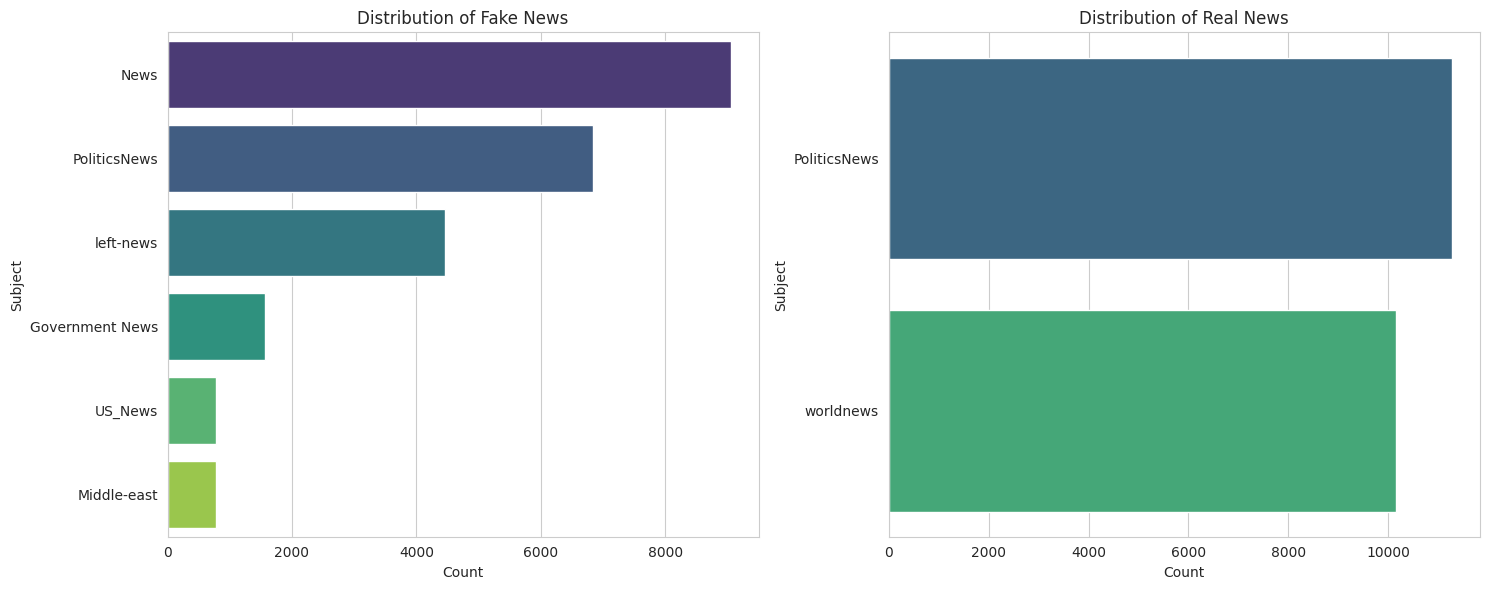

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Fake news distribution
sns.barplot(ax=axs[0], x='count', y='subject', data=rs1, palette='viridis')
axs[0].set_title('Distribution of Fake News')
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Subject')

# Real news distribution
sns.barplot(ax=axs[1], x='count', y='subject', data=rs2, palette='viridis')
axs[1].set_title('Distribution of Real News')
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Subject')

# Adjust layout
plt.tight_layout()
plt.show()


 <div style = "height: 230px;
  width: 800px;
  border:5px inset blue;
  background-color: #e2e1e9;">
    <h3 style="
              color:black;
               ">
        <b>Observations:</b> 
    <p>
        <ol>
            <li>The subjects that hold more real news are:
                <ul>
                    <li>PoliticsNews - 49.71%</li>
                    <li>worldnews - 44.93%</li>
                </ul>
            </li>
            <li>The subjects that hold more fake news are:
                <ul>
                    <li>News - 39.09%</li>
                    <li>PoliticsNews - 29.59%</li>
                    <li>left-news - 19.28%</li>
                </ul>
            </li>
        </ol>
    </p>
</div>


***
### how is the Distribution of some features ?

In [12]:
data['date'] = pd.to_datetime(data['date'],format='mixed', dayfirst=True,errors='coerce')

data['Year'] = data['date'].dt.year
data['Month'] = data['date'].dt.month_name()

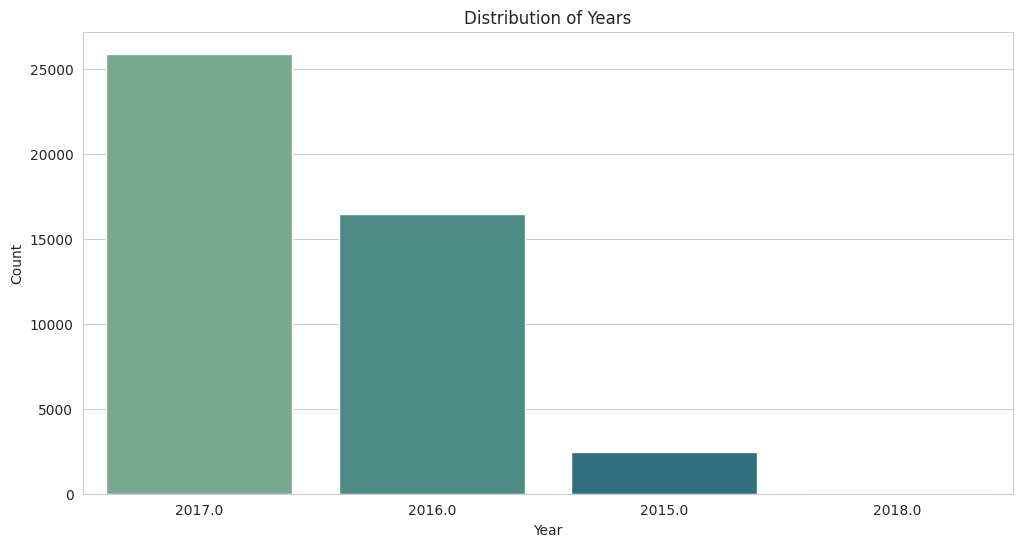

In [13]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Year', data=data, order=data['Year'].value_counts().index, palette='crest')
plt.title('Distribution of Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

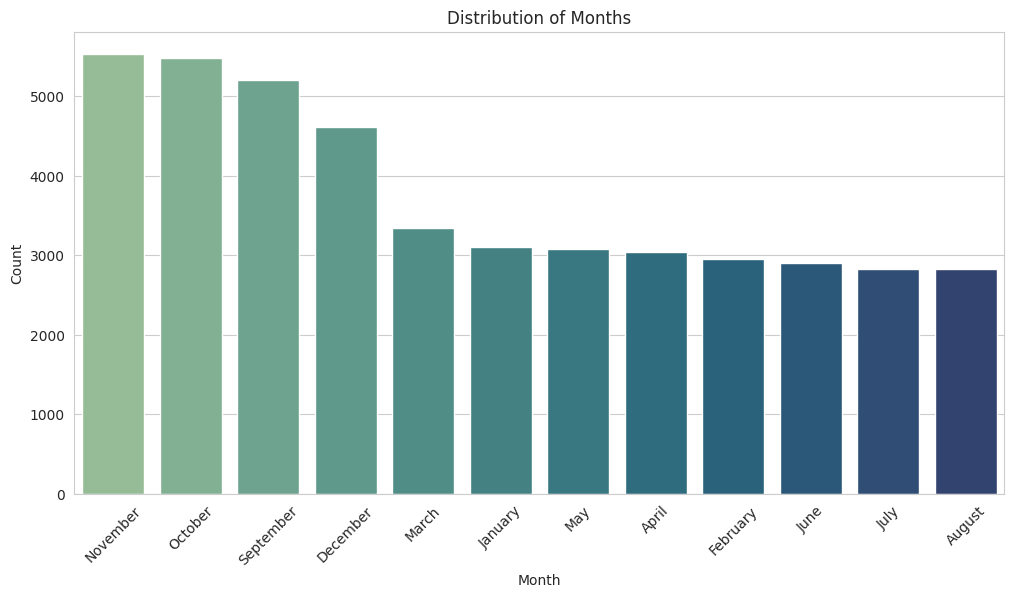

In [14]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', data=data, order=data['Month'].value_counts().index, palette='crest')
plt.title('Distribution of Months')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

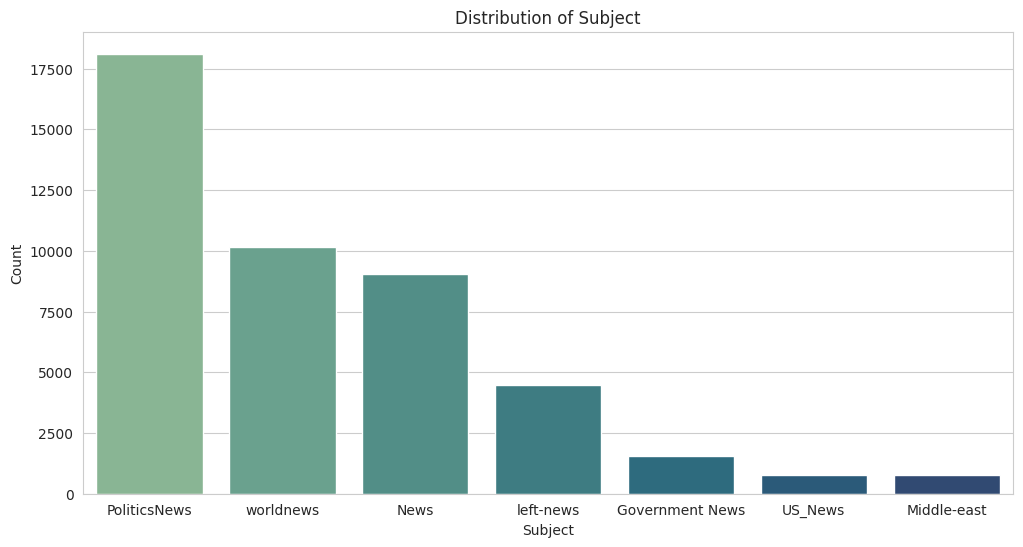

In [15]:
plt.figure(figsize=(12, 6))
sns.countplot(x='subject', data=data , order=data['subject'].value_counts().index, palette='crest')
plt.title('Distribution of Subject')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

***
### Question: Is there a link between the title length and the target variable?



In [16]:
import nltk
df = pd.DataFrame()
def count_words(column):
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    new_words = tokenizer.tokenize(column)
    return len(new_words)

df["n_words_in_title"]=data["title"].apply(count_words)
df["n_words_in_text"]=data["text"].apply(count_words)
df['target']=data['target']

<Axes: title={'center': 'Number of words in the title.'}, xlabel='target', ylabel='n_words_in_title'>

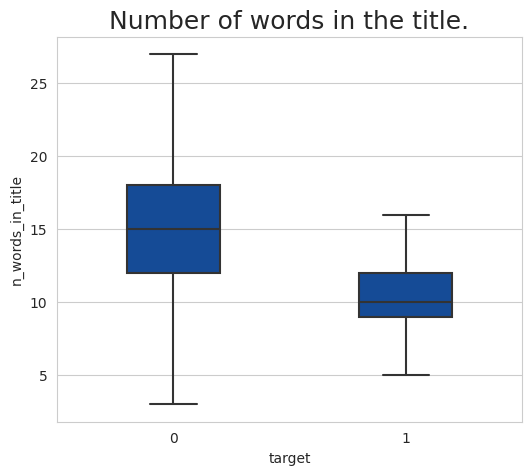

In [17]:
fig=plt.figure(figsize=[6,5])
# fig.patch.set_alpha(0.7)

plt.title("Number of words in the title.",size=18)
sns.boxplot(data=df, x="target",y="n_words_in_title",showfliers=False,width=0.4,color="#0047AB")

<Axes: title={'center': 'Number of words in the text.'}, xlabel='target', ylabel='n_words_in_text'>

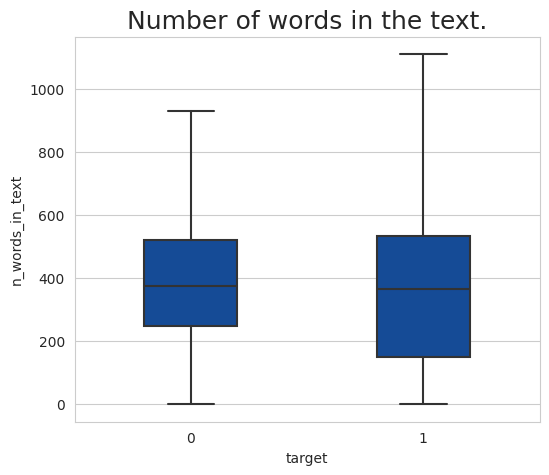

In [18]:
fig=plt.figure(figsize=[6,5])
# fig.patch.set_alpha(0.7)

plt.title("Number of words in the text.",size=18)
sns.boxplot(data=df, x="target",y="n_words_in_text",showfliers=False,width=0.4,color="#0047AB")

<div style="height: 90px;
            width: 800px;
            border: 5px inset blue;
            background-color: #e2e1e9;">
    <h3 style="color: black;">
        <ul>
            <li>It seems that fake news have longer titles, but relatively shorter content (text).</li>
        </ul>
    </h3>
</div>


***
<h3 style="font-size: 45px; text-align: center; font-family: Copperplate; color: darkblue; background-color: white;">Text pre procesing</h3>


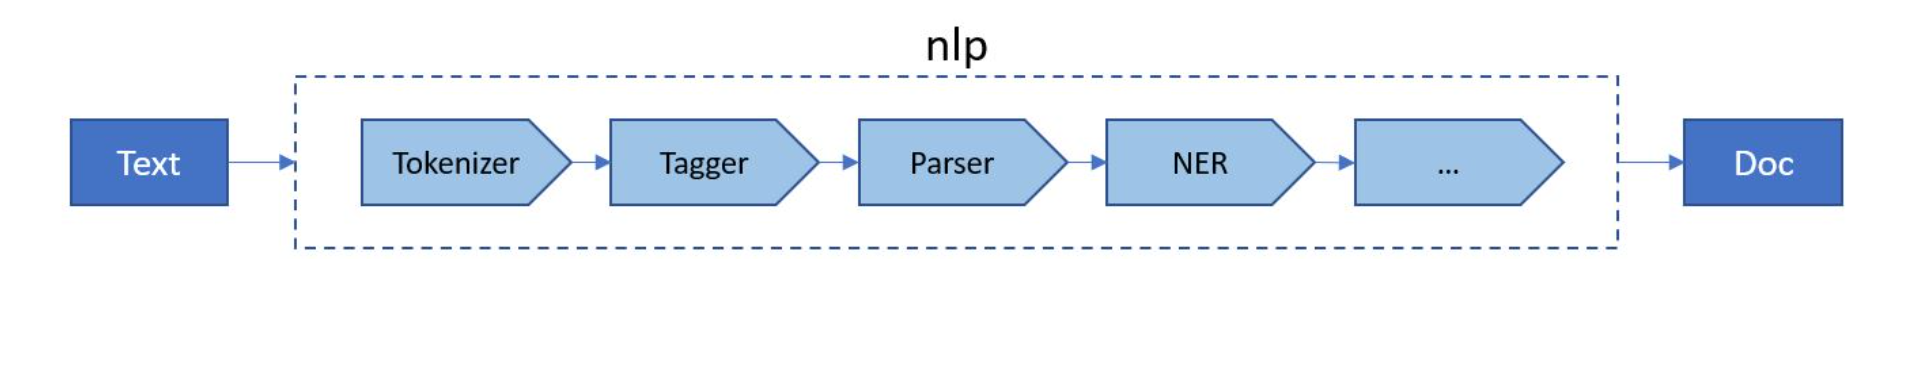

In [19]:
data['final'] =  data['title'] + " " + data['subject']


In [20]:
import re  # Import the regular expressions module
import string  # Import the string module containing punctuation

def wordopt(text):
    # Convert the entire text to lowercase
    text = text.lower()

    # Remove text within square brackets, including the brackets
    text = re.sub('\[.*?\]', '', text)

    # Replace all non-alphabetic characters with a space
    text = re.sub("\\W", " ", text)

    # Remove URLs
    text = re.sub('https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub('<.*?>', '', text)

    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    # Remove words containing digits
    text = re.sub('\w*\d\w*', '', text)

    return text  # Return the preprocessed text


In [21]:
data['final'] = data['final'].apply(wordopt)
data.final

0         breaking  gop chairman grassley has had enoug...
1         failed gop candidates remembered in hilarious...
2         mike pence s new dc neighbors are hilariously...
3        california ag pledges to defend birth control ...
4        az ranchers living on us mexico border destroy...
                               ...                        
44893    nigeria says u s  agrees delayed   million fig...
44894          boiler room     fatal illusions middle east
44895    atheists sue governor of texas over display on...
44896    republican tax plan would deal financial hit t...
44897    u n  refugee commissioner says australia must ...
Name: final, Length: 44898, dtype: object

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

X_train,X_test,y_train,y_test = train_test_split(data['final'],data['target'],test_size=0.3)
# cv = CountVectorizer(min_df=0,max_df=1,ngram_range=(1,2))

# cv_train = cv.fit_transform(X_train)
# cv_test = cv.transform(X_test)
vectorization = TfidfVectorizer()
cv_train = vectorization.fit_transform(X_train)
cv_test = vectorization.transform(X_test)

print('Train shape: ',cv_train.shape)
print('Test shape: ',cv_test.shape)

Train shape:  (31428, 18396)
Test shape:  (13470, 18396)


In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


nb = MultinomialNB()
nb.fit(cv_train, y_train)
pred_nb = nb.predict(cv_test)
score = accuracy_score(y_test, pred_nb)
print("Accuracy Score: ",score)


Accuracy Score:  0.955902004454343


***

In [24]:
# data['final2'] =  data['text'] + " " + data['title'] + " " + data['subject']
data['final2'] =  data['text'] + " " + data['title'] + " " + data['subject']

data['final2'] = data['final2'].apply(wordopt)
data['final2'].head(3)


0    donald trump s white house is in chaos  and th...
1    now that donald trump is the presumptive gop n...
2    mike pence is a huge homophobe  he supports ex...
Name: final2, dtype: object

In [25]:
X_train,X_test,y_train,y_test = train_test_split(data['final2'],data['target'],test_size=0.2)
# cv = CountVectorizer(min_df=0,max_df=1,ngram_range=(1,2))
vectorization = TfidfVectorizer()

cv_train = vectorization.fit_transform(X_train)
cv_test = vectorization.transform(X_test)

print('Train shape: ',cv_train.shape)
print('Test shape: ',cv_test.shape)



nb = MultinomialNB()
nb.fit(cv_train, y_train)

pred_nb = nb.predict(cv_test)
score = accuracy_score(y_test, pred_nb)
print("Accuracy Score: ",score)

Train shape:  (35918, 97979)
Test shape:  (8980, 97979)
Accuracy Score:  0.9387527839643652


<div style="height: 100px;
            width: 1000px;
            border: 5px inset blue;
            background-color: #e2e1e9;">
    <h3 style="color: black;">
        <ul>
            <li> The prediction accuracy based on the title and subject alone is 0.95 , Adding the text to it and its 0.91 . 
            that can be due to the fact that the title is moe representive and affected by fake news ( longer in fake news )  . 
                    </li>
        </ul>
    </h3>
</div>


***
<h3 style="font-size: 45px; text-align: center; font-family: Copperplate; color: darkblue; background-color: white;">Creating a pipeline</h3>



[link](https://neptune.ai/blog/building-ml-model-training-pipeline)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
listt=[]
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(data['final2'], data['target'], test_size=0.2)

# Vectorize the data
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Creating a combined pipeline with model training
pipeline_combined = Pipeline([
    ('model', LogisticRegression())  # Default model, will be replaced later
])

# Fit and evaluate each model in the combined pipeline
for model_name, model in [('logistic', LogisticRegression()), ('decision_tree', DecisionTreeClassifier()), ('random_forest', RandomForestClassifier())]:
    pipeline_combined.set_params(model=model)  # Set the current model in the pipeline
    pipeline_combined.fit(X_train_vec, y_train)  # Fit the pipeline with vectorized data
    y_pred = pipeline_combined.predict(X_test_vec)  # Predict with the current model using vectorized test data
    accuracy = accuracy_score(y_test, y_pred) 
    listt.append(accuracy)
    print(f"{model_name.capitalize().replace('_', ' ')} Accuracy:", accuracy)


Logistic Accuracy: 0.9888641425389755
Decision tree Accuracy: 0.9959910913140312
Random forest Accuracy: 0.9926503340757238


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


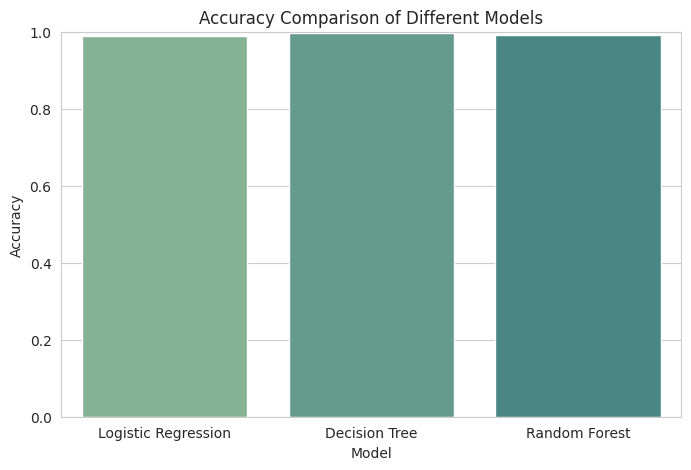

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']
accuracies = listt

# Create a bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.ylim(0, 1)  
plt.show()
